<a href="https://colab.research.google.com/github/Siarzis/ai-tutor/blob/main/lfc_disturbance_prediction_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [66]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

Load and plot the training data

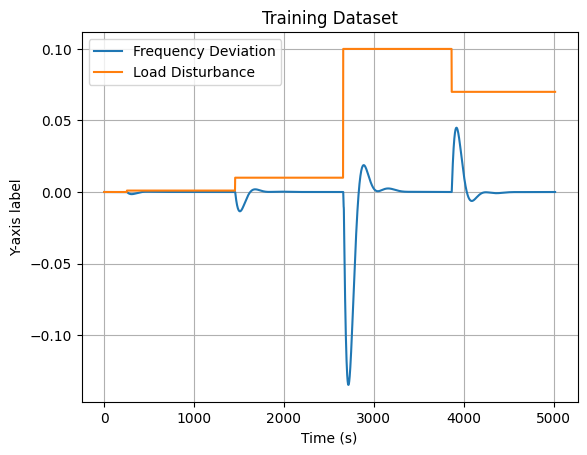

In [67]:
train_dataset_df = pd.read_csv('train_dataset.csv', dtype=np.float32)

plt.figure()
plt.plot(train_dataset_df.iloc[:, 1], label='Frequency Deviation')
plt.plot(train_dataset_df.iloc[:, 2], label='Load Disturbance')
plt.xlabel('Time (s)')
plt.ylabel('Y-axis label')
plt.title('Training Dataset')
plt.legend()
plt.grid(True)
plt.show()

Load and plot the testing data

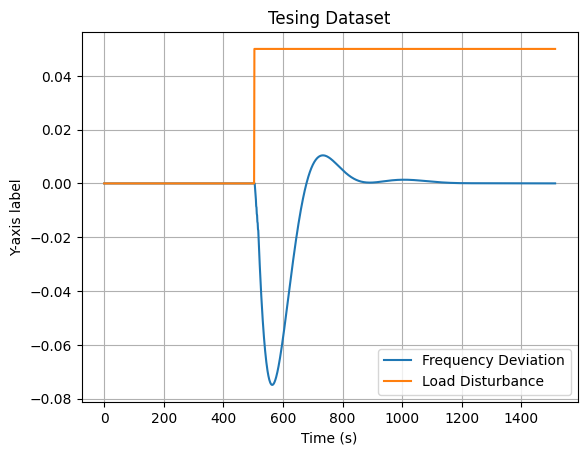

In [68]:
test_dataset_df = pd.read_csv('test_dataset.csv', dtype=np.float32)

plt.figure()
plt.plot(test_dataset_df.iloc[:, 1], label='Frequency Deviation')
plt.plot(test_dataset_df.iloc[:, 2], label='Load Disturbance')
plt.xlabel('Time (s)')
plt.ylabel('Y-axis label')
plt.title('Tesing Dataset')
plt.legend()
plt.grid(True)
plt.show()

Data preprocess

**Pipeline description**: csv format → data frame → numpy → tensor





In [69]:
def windowed_array(arr, window_size):
    # Calculate the number of subarrays
    num_windows = len(arr) - window_size + 1

    # Create an empty array to store the result
    result = np.empty((num_windows, window_size), dtype=arr.dtype)

    # Fill the result array with windowed slices
    for i in range(num_windows):
        result[i] = arr[i:i+window_size]

    return result

class CustomDataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = torch.tensor(inputs)
        self.outputs = torch.tensor(outputs)

    def __len__(self):
        return len(self.inputs)  # Assuming all arrays have the same length

    def __getitem__(self, index):
        sample = tuple((self.inputs[index], self.outputs[index]))
        return sample

In [70]:
# for now, keep historical_window equal to prediction_window
# if not equal, the consider padding method
historical_window = 10
prediction_window = 10

# training data preprocess

X_train = train_dataset_df.iloc[:, 1].to_numpy()
y_train = train_dataset_df.iloc[:, 2].to_numpy()

X_train = X_train[:len(X_train)-historical_window]
y_train = y_train[prediction_window:]

X_train = windowed_array(X_train, historical_window)
y_train = windowed_array(y_train, prediction_window)

train_tensor = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_tensor, batch_size=64, shuffle=True)

# testing data preprocess

X_test = test_dataset_df.iloc[:, 1].to_numpy()
y_test = test_dataset_df.iloc[:, 2].to_numpy()

X_test = X_test[:len(X_test)-historical_window]
y_test = y_test[prediction_window:]

X_test = windowed_array(X_test, historical_window)
y_test = windowed_array(y_test, prediction_window)

test_tensor = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_tensor, batch_size=64, shuffle=True)

Definition & initilization of MLP

In [71]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [72]:
# define feedforward neural network architecture
input_size = historical_window
hidden_size = 100
output_size = prediction_window

# Check for GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# create an instance of the neural network
net = MLP(input_size, hidden_size, output_size)
net = nn.DataParallel(net)
net = net.to(device)

# define loss function and optimizer
criterion = nn.MSELoss() # for classification tasks logarithmic/cross-entropy loss function is mainly used
optimizer = optim.SGD(net.parameters(), lr=0.01)

Training of MLP

In [73]:
epochs = 100
training_loss = []

for e in range(epochs):

    total_batch_loss = 0.0
    average_batch_loss = 0.0

    # forward pass
    for i_batch, (timeseries_batch, label_batch) in enumerate(train_loader):

        timeseries_batch = timeseries_batch.to(device)
        label_batch = label_batch.to(device)

        # nullify gradients for every batch
        optimizer.zero_grad()

        output = net(timeseries_batch)

        # compute loss and store the total loss in each epoch
        loss = criterion(output, label_batch)
        total_batch_loss += loss.item()

        # backpropagation
        loss.backward() # propagate the loss backwards
        optimizer.step() # update weights

    average_batch_loss = total_batch_loss / len(train_loader)
    training_loss.append(average_batch_loss)

    print('Epoch [{}/{}], Loss: {:.4f}'.format(e+1, epochs, average_batch_loss))

Epoch [1/100], Loss: 0.0070
Epoch [2/100], Loss: 0.0040
Epoch [3/100], Loss: 0.0027
Epoch [4/100], Loss: 0.0022
Epoch [5/100], Loss: 0.0019
Epoch [6/100], Loss: 0.0018
Epoch [7/100], Loss: 0.0018
Epoch [8/100], Loss: 0.0017
Epoch [9/100], Loss: 0.0017
Epoch [10/100], Loss: 0.0017
Epoch [11/100], Loss: 0.0017
Epoch [12/100], Loss: 0.0017
Epoch [13/100], Loss: 0.0017
Epoch [14/100], Loss: 0.0017
Epoch [15/100], Loss: 0.0017
Epoch [16/100], Loss: 0.0017
Epoch [17/100], Loss: 0.0017
Epoch [18/100], Loss: 0.0017
Epoch [19/100], Loss: 0.0017
Epoch [20/100], Loss: 0.0017
Epoch [21/100], Loss: 0.0017
Epoch [22/100], Loss: 0.0017
Epoch [23/100], Loss: 0.0017
Epoch [24/100], Loss: 0.0017
Epoch [25/100], Loss: 0.0017
Epoch [26/100], Loss: 0.0017
Epoch [27/100], Loss: 0.0017
Epoch [28/100], Loss: 0.0017
Epoch [29/100], Loss: 0.0017
Epoch [30/100], Loss: 0.0017
Epoch [31/100], Loss: 0.0017
Epoch [32/100], Loss: 0.0017
Epoch [33/100], Loss: 0.0017
Epoch [34/100], Loss: 0.0017
Epoch [35/100], Loss: 0

Plot training loss

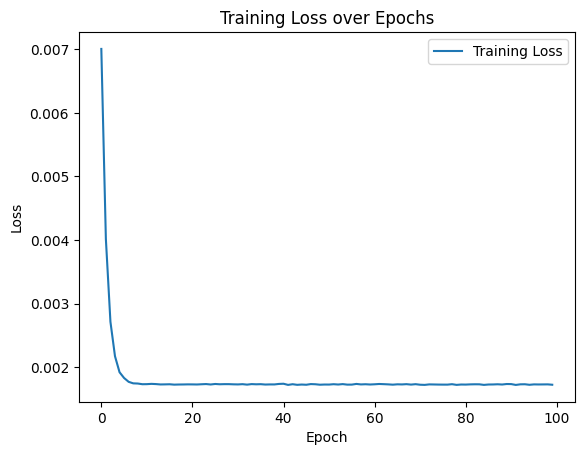

In [74]:
# Plot the training loss
plt.plot(training_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

Model evaluation

In [75]:
num_points = 1000
seq_length = 10

sine_values = np.sin(np.linspace(0, 10*np.pi, num_points))
cosine_values = np.cos(np.linspace(0, 10*np.pi, num_points))

# Convert to PyTorch tensors
sine_tensor = torch.tensor(sine_values, dtype=torch.float32)
cosine_tensor = torch.tensor(cosine_values, dtype=torch.float32)

# Create sequences of sine values as input and corresponding cosine values as output
input_data = torch.stack([sine_tensor[i:i+seq_length] for i in range(num_points - seq_length)]).unsqueeze(2)
output_data = torch.stack([cosine_tensor[i+seq_length] for i in range(num_points - seq_length)]).unsqueeze(1)

print(input_data[0], output_data[0])

tensor([[0.0000],
        [0.0314],
        [0.0629],
        [0.0942],
        [0.1255],
        [0.1566],
        [0.1876],
        [0.2184],
        [0.2489],
        [0.2793]]) tensor([0.9510])
